<a href="https://colab.research.google.com/github/ShimHyerin/2021-VehicleIntelligence/blob/main/HW3/LaneNet_Report3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 191 (delta 55), reused 154 (delta 27), pack-reused 0
Receiving objects: 100% (191/191), 29.32 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


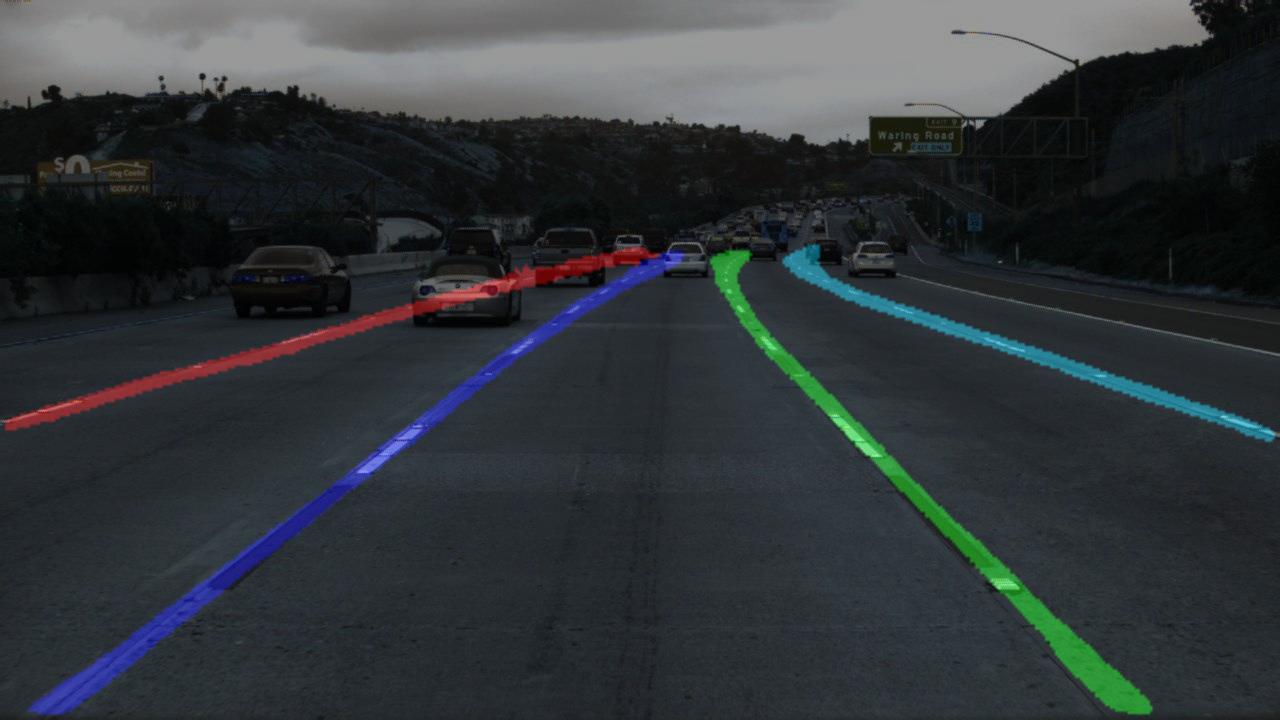

In [ ]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

In [ ]:
def video2segemented_video(video_path, filename):
    # TODO: video to frames

    cap = cv2.VideoCapture(video_path+filename)
    success,img = cap.read()
    if success == False:
      print("No video File")
      return 0
    add_img = np.hstack((img, inference(img)))
    cv2_imshow(add_img)

    frames = []
    add_frames = []
    fps = 30
    height, width, layers = img.shape
    size = (width, height)
    a_height, a_width, a_layers = add_img.shape
    add_size = (a_width, a_height)

    while success:
      success,img = cap.read()
      if success==False: break
      add_img = np.hstack((img, inference(img)))
      add_frames.append(add_img)
      frames.append(inference(img))

    file = filename.split('.')
    outfile = file[0]+"_fin."+file[1]
    outfile_add = file[0]+"_add."+file[1]
    print("Check out the output video from viedo_path on your Google drive!")
    print("output: ", outfile)
    output = cv2.VideoWriter(video_path+outfile, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    print("output: ", outfile_add)
    output_add = cv2.VideoWriter(video_path+outfile_add, cv2.VideoWriter_fourcc(*'DIVX'), fps, add_size)
    for i in range(len(frames)):
      output.write(frames[i])
      output_add.write(add_frames[i])
    output.release()
    output_add.release()
    pass

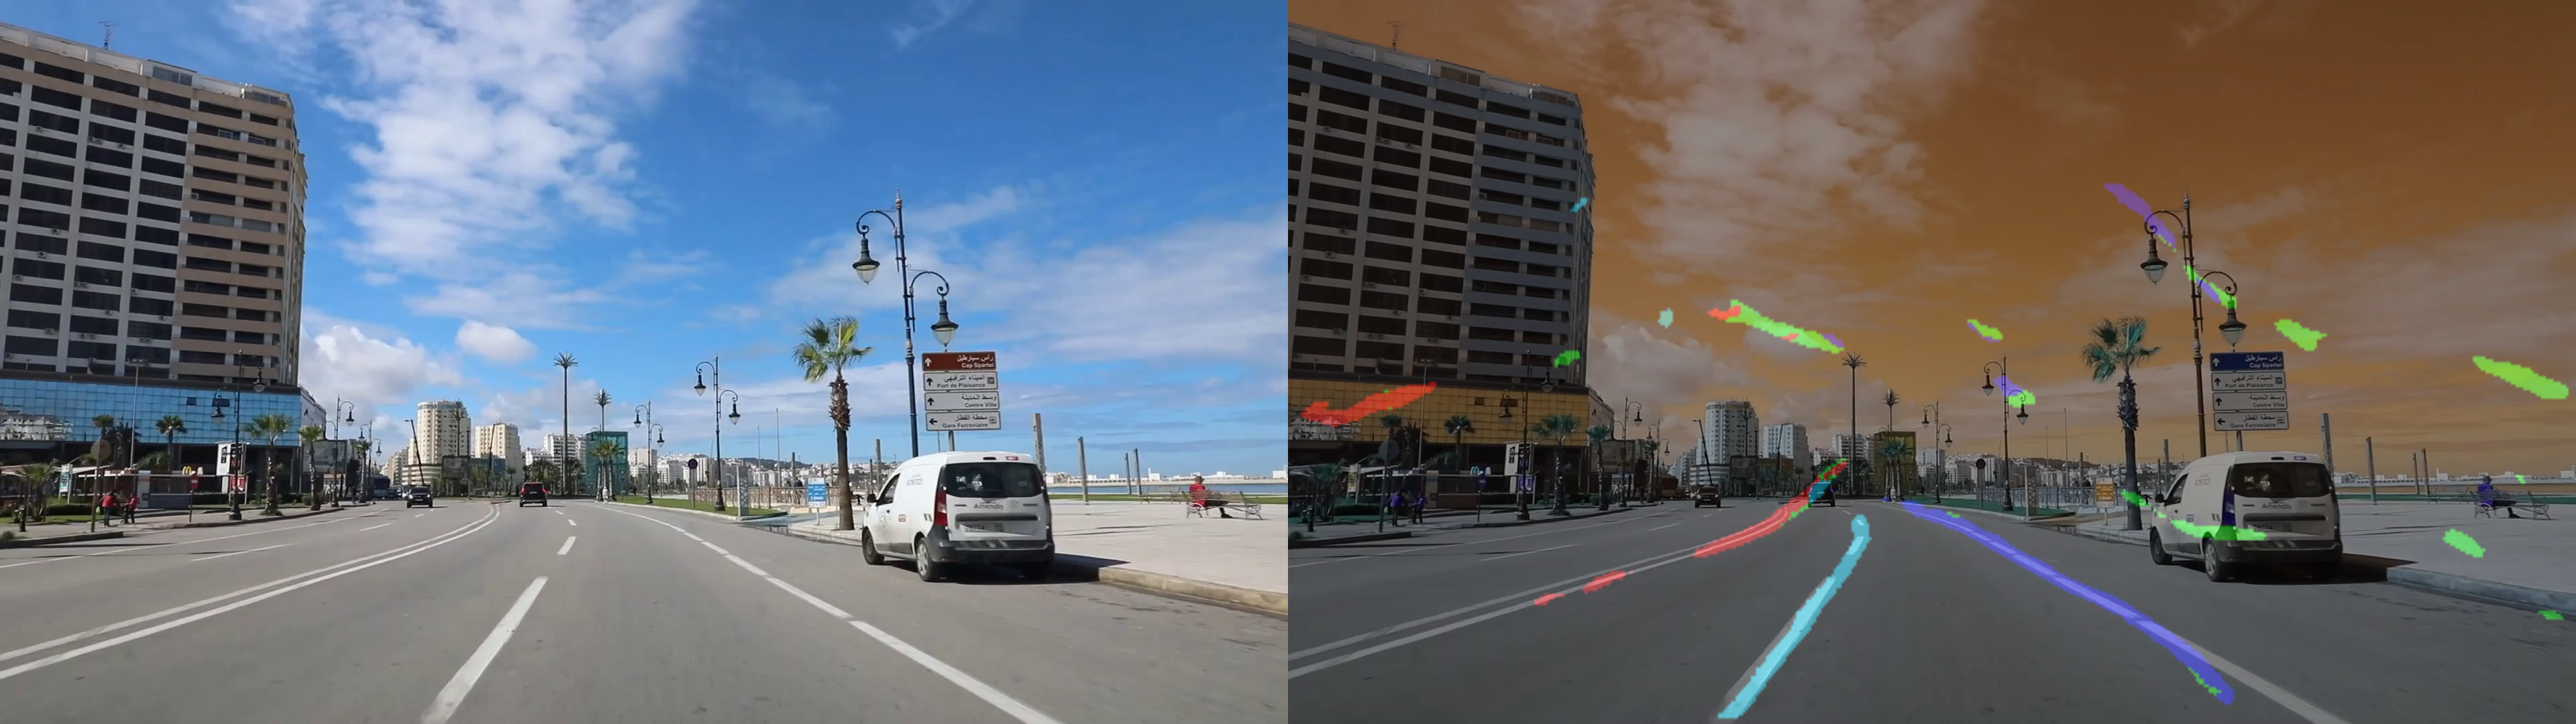

Check out the output video from viedo_path on your Google drive!
output:  test_fin.mp4
output:  test_add.mp4


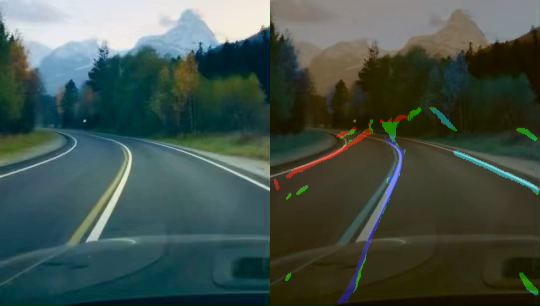

Check out the output video from viedo_path on your Google drive!
output:  test2_fin.mp4
output:  test2_add.mp4


In [ ]:
# Test
video_path = "/content/drive/MyDrive/LaneNetReport/" # input your video path
video2segemented_video(video_path, "test.mp4")
video2segemented_video(video_path, "test2.mp4")